In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torchvision
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, average_precision_score,auc,roc_curve, precision_recall_fscore_support
import pandas as pd
import resplot

## Set parameters and define helper functions

In [2]:
DEVICE = th.device("cuda:2" if th.cuda.is_available() else "cpu")

args = dict()
args['dim_h'] = 40         # factor controlling size of hidden layers
args['n_channel'] = 3      # number of channels in the input data (MNIST = 1, greyscale)
args['n_z'] = 128           # number of dimensions in latent space. 
args['sigma'] = 0.1        # variance in n_z
args['lr'] = 0.0001        # learning rate for Adam optimizer
args['epochs'] = 401       # how many epochs to run for
args['batch_size'] = 32   # batch size for SGD
args['save'] = False       # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from saved weights

args['scheduler'] = True   # use scheduler for learning rate or not
args['inClass'] = 0        # set which is the class of the inliers

args['subspace_reg']=0.0   # weight for subspace regularization, 0 if not applied
args['wae']=0.1           # WAE-GAN discriminator lambda, 0 if not WAE
args['lipschitz']=0        # Lipschitz penalty weight, 0 if not applied
args['advantage']=True     # Advantage penalty 

args['outratio'] = 0.3     # outlier ration in unlabeled dataset
args['seed'] = 14           # seed for randomness

seed = args['seed']
np.random.seed(seed)
th.manual_seed(seed)

zero = th.tensor([0], dtype=th.float).cuda().to(DEVICE)
one = th.tensor([1], dtype=th.float).cuda().to(DEVICE)

#USEFUL FUNCTIONS

# methods to freeze/free parameters for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False
        
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


In [3]:
import celebEncoder
import celebDecoder

## Neural Networks for Encoder, Decoders, Discriminator

In [4]:
import celebEncoder
import celebDecoder
# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

## Prepare dataset

In [5]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize([64, 64]),transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])


positive = torchvision.datasets.ImageFolder(root='./prepared_celeba/positive',transform=TRANSFORM_IMG)
unlabeled = torchvision.datasets.ImageFolder(root='./prepared_celeba/unlabeled',transform=TRANSFORM_IMG)

In [6]:
len(positive)

176213

In [7]:
len(unlabeled)

26386

In [8]:
positive_loader = DataLoader(
    dataset=positive,
    batch_size=int(args['batch_size']*(len(positive)/len(unlabeled))),
    drop_last=False,
    shuffle=True
)

unlabeled_loader = DataLoader(
    dataset=unlabeled,
    batch_size=args['batch_size'],
    drop_last=False,
    shuffle=True
)

In [9]:
for x in unlabeled_loader:
    break

In [10]:
x[0].shape

torch.Size([32, 3, 64, 64])

## Initialize models and optimizers

In [11]:
error = nn.MSELoss(reduction='none')
criterion = nn.MSELoss()

encoder = celebEncoder.celebA_Encoder(d_latent=args['n_z']).cuda().to(DEVICE)
decoderI = celebDecoder.celebA_Decoder(d_latent=args['n_z']).cuda().to(DEVICE)
decoderO = celebDecoder.celebA_Decoder(d_latent=args['n_z']).cuda().to(DEVICE)
discriminator = Discriminator(args).cuda().to(DEVICE)
decoderI.load_state_dict(decoderO.state_dict())

enc_optim = th.optim.Adam(encoder.parameters(), lr = args['lr'])
decI_optim = th.optim.Adam(decoderI.parameters(), lr = args['lr'])
decO_optim = th.optim.Adam(decoderO.parameters(), lr = args['lr'])
dis_optim = th.optim.Adam(discriminator.parameters(), lr = args['lr'])

if args['scheduler']:
    enc_scheduler = th.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    decI_scheduler = th.optim.lr_scheduler.StepLR(decI_optim, step_size=30, gamma=0.5)
    decO_scheduler = th.optim.lr_scheduler.StepLR(decO_optim, step_size=30, gamma=0.5)
    dis_scheduler = th.optim.lr_scheduler.StepLR(dis_optim, step_size=30, gamma=0.5)

Number of celebA_encoder parameters: 19021184
Number of celebA_decoder parameters: 17127555
Number of celebA_decoder parameters: 17127555


## Semi-supervised training 

In [12]:
print("Epoch\tLoss\tAdv\tPrec\tRec\tF1\tAUC")

advantageI = th.tensor([0], dtype=th.float).cuda().to(DEVICE)
for epoch in range(args['epochs']):
    y_pred = []
    scoreI = []
    unlabeled_labels = []
    for cnt, x in enumerate(zip(positive_loader, unlabeled_loader)):
        #split the dataset int positive p, unlabeled u, both combined x
        p = x[0][0].cuda().to(DEVICE)
        u = x[1][0].cuda().to(DEVICE)
        ulbls = x[1][1]
        x = th.cat((p,u),0)
        
        #zero the gradients
        encoder.zero_grad()
        decoderI.zero_grad()
        decoderO.zero_grad()
        discriminator.zero_grad()
        
        if args['wae'] > 0:
            ###################### TRAIN DISCRIMINATOR ######################

            # freeze auto encoder params
            frozen_params(decoderI)
            frozen_params(decoderO)
            frozen_params(encoder)
            # free discriminator params
            free_params(discriminator)

            # run discriminator against randn draws
            z = (th.randn(p.size()[0], args['n_z']) * args['sigma']).cuda().to(DEVICE)
            d_z = discriminator(z)

            # run discriminator against encoder z's
            z_hat = encoder(p)
            d_z_hat = discriminator(z_hat)

            d_z_loss = args['wae']*th.log(d_z).mean()
            d_z_hat_loss = args['wae']*th.log(1 - d_z_hat).mean()

            # formula for ascending the descriminator -- -one reverses the direction of the gradient.
            d_z_loss.backward(-one)
            d_z_hat_loss.backward(-one)

            dis_optim.step()
        
        
        ###################### TRAIN AUTOENCODER ######################

        # flip which networks are frozen, which are not
        free_params(decoderI)
        free_params(decoderO)
        free_params(encoder)
        frozen_params(discriminator)


        # encode positive and unlabeled
        z_hatP = encoder(p)
        z_hatU = encoder(u)
        
        # decode positive with inlier decoder
        x_hatP = decoderI(z_hatP)
        
        # decode unlabeled with both decoders
        x_hatUO = decoderO(z_hatU)
        x_hatUI = decoderI(z_hatU)
        
        #resplot.plot_rows(unlabeled,args,encoder,decoders = [decoderI,decoderO], seed = seed)
        
        lossI = error(x_hatP,p).mean(axis=(1,2,3))
        lossUI = error(x_hatUI,u).mean(axis=(1,2,3))
        lossUO = error(x_hatUO,u).mean(axis=(1,2,3))
    
        #compute advantage on best reconstructed sample to make training stable.
        if args['advantage']:
            advantageI = lossUO.min() - lossI.min()
        
        # compute y based on the decoder with lower error.
        y = ulbls.float().cuda().to(DEVICE)
        
        scoreI.extend(list(lossUI.detach().cpu().numpy()))
                
        # append this prediction to evaluate when the epoch ends
        
        y_pred.extend(list(y.cpu().numpy()))
        
        unlabeled_labels.extend(list(ulbls))
        
                
        # compute competitive AE loss
        loss = th.mean(y*lossUO + (1-y)*lossUI) + th.mean(lossI)

        if(args['subspace_reg']>0):
            z_hat2 = th.cat((z_hatP,z_hatU),0).detach()
            ws = th.exp(-th.pdist(x.reshape(x.shape[0],-1)/args['subspace_reg'],2))
            o_len = (int)(x.shape[0]/4)
            ws[-o_len:]=0
            diff = th.pow(th.pdist(z_hat2,1),2)
            loss += args['subspace_reg'] * th.mean(ws*diff)
        
        if(args['wae'])>0: 
            z_hat = encoder(p)
            # discriminate latents        
            d_z_hat = discriminator(z_hat)
            # calculate discriminator loss
            d_loss = args['wae'] * (th.log(d_z_hat)).mean()
            # compute gradient to fool discriminator
            d_loss.backward(-one)
            
        loss.backward(one)
        
        enc_optim.step()
        decI_optim.step()
        decO_optim.step()
        
    
    if epoch % 5 == 0:
        precision, recall, F1, _ = precision_recall_fscore_support(unlabeled_labels,
                                                               y_pred,
                                                               average='binary')
        AUC = roc_auc_score(unlabeled_labels,scoreI)
        
        print("%d\t%1.3f\t%1.3f\t%1.3f\t%1.3f\t%1.3f\t%1.3f" % (epoch,loss.item(),advantageI,precision, recall,F1,AUC))
    
        

Epoch	Loss	Adv	Prec	Rec	F1	AUC


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


0	0.051	0.010	1.000	1.000	1.000	0.580
5	0.048	0.008	1.000	1.000	1.000	0.591
10	0.037	-0.001	1.000	1.000	1.000	0.591
15	0.039	0.010	1.000	1.000	1.000	0.599
20	0.031	0.004	1.000	1.000	1.000	0.605
25	0.029	0.004	1.000	1.000	1.000	0.617
30	0.027	0.002	1.000	1.000	1.000	0.617
35	0.022	0.005	1.000	1.000	1.000	0.625
40	0.050	0.007	1.000	1.000	1.000	0.585
45	0.020	0.004	1.000	1.000	1.000	0.608
50	0.017	0.003	1.000	1.000	1.000	0.630
55	0.014	0.001	1.000	1.000	1.000	0.639
60	0.015	0.002	1.000	1.000	1.000	0.648
65	0.013	0.005	1.000	1.000	1.000	0.653
70	0.016	0.002	1.000	1.000	1.000	0.662
75	0.012	0.004	1.000	1.000	1.000	0.686
80	0.013	0.003	1.000	1.000	1.000	0.698
85	0.012	0.003	1.000	1.000	1.000	0.702
90	0.012	0.003	1.000	1.000	1.000	0.706
95	0.012	0.003	1.000	1.000	1.000	0.713
100	0.011	0.002	1.000	1.000	1.000	0.719
105	0.011	0.003	1.000	1.000	1.000	0.724
110	0.011	0.003	1.000	1.000	1.000	0.735
115	0.011	0.002	1.000	1.000	1.000	0.740
120	0.010	0.003	1.000	1.000	1.000	0.745
125	0.010	0.003	1.000

KeyboardInterrupt: 

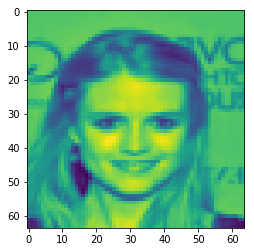

In [13]:
plt.imshow(positive[10][0][0])

In [27]:
th.save(encoder.state_dict(), "celeb_enc.state")
th.save(decoderI.state_dict(), "celeb_decI.state")
th.save(decoderO.state_dict(), "celeb_decO.state")
th.save(discriminator.state_dict(), "celeb_disc.state")

In [31]:
encoded_positive = encoder(p)
positive_I_decoded = np.rollaxis(decoderI(encoded_positive), 3, 1) 
positive_O_decoded = np.rollaxis(decoderO(encoded_positive),3,1)

RuntimeError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 2; 10.92 GiB total capacity; 9.87 GiB already allocated; 18.56 MiB free; 39.01 MiB cached)

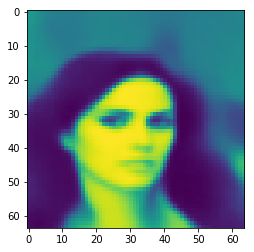

In [23]:
positive_I_decoded.cpu().detach().numpy()[0].shape
plt.imshow(positive_I_decoded.cpu().detach().numpy()[1][0])

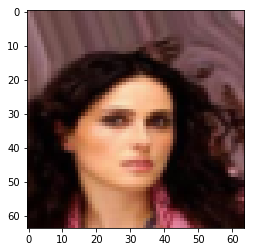

In [62]:
plt.imshow(np.moveaxis(p.cpu().detach().numpy()[1],0,2))

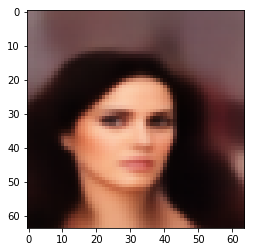

In [44]:
plt.imshow(np.moveaxis(positive_I_decoded.cpu().detach().numpy()[1],0,2))

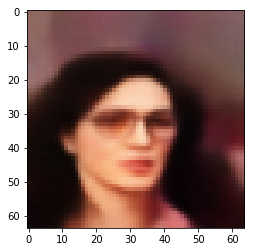

In [43]:
plt.imshow(np.moveaxis(positive_O_decoded.cpu().detach().numpy()[1],0,2))

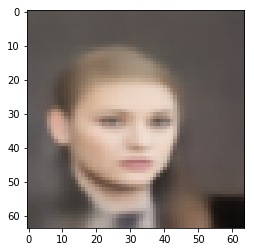

In [47]:
plt.imshow(np.moveaxis(positive_I_decoded.cpu().detach().numpy()[3],0,2))

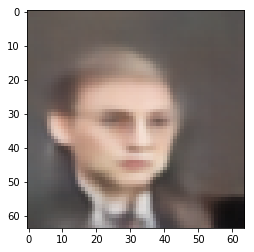

In [48]:
plt.imshow(np.moveaxis(positive_O_decoded.cpu().detach().numpy()[3],0,2))

In [54]:
outliers = u[ulbls==1]
encoded = encoder(outliers)
outliers_I_decoded = decoderI(encoded)
outliers_O_decoded = decoderO(encoded)

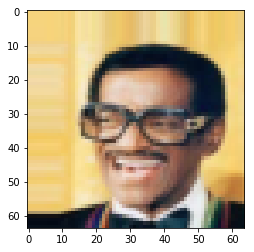

In [59]:

plt.imshow(np.moveaxis(u[ulbls==1].cpu().detach().numpy()[0],0,2))

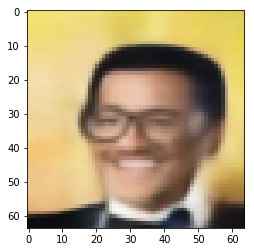

In [58]:
plt.imshow(np.moveaxis(outliers_O_decoded.cpu().detach().numpy()[0],0,2))

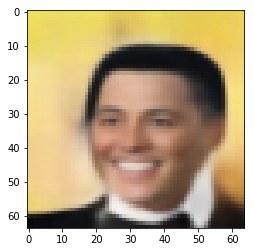

In [57]:
plt.imshow(np.moveaxis(outliers_I_decoded.cpu().detach().numpy()[0],0,2))

In [34]:
plt.imshow(decoderO(encoder(th.FloatTensor(positive[10]).cuda().to(DEVICE).reshape(1,3,64,64))).reshape(64,64,3).cpu().detach().numpy())

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
positive[10]